In [1]:
# imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential, layers

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [2]:
path=('../thermofeeler/data/tokenized_dataset.csv')
df = pd.read_csv(path)
df.head()

,Unnamed: 0,tweet_text,encoded_sentiment
0,0,"['fato', 'acho', 'roger', 'é', 'bom', 'nome', ...",0
1,1,"['novidade', 'acaba', 'anunciar', 'novo', 'voo...",0
2,2,"['tem', 'novidade', 'tem', 'área', 'cadaumnasu...",0
3,3,"['novidade', 'taí', 'sucesso', 'filhos', 'lula...",0
4,4,"['livronovidades', 'segredos', 'história', 'lu...",0


In [3]:
df.describe()

,Unnamed: 0,encoded_sentiment
count,159849.000000,159849.000000
mean,79924.000000,0.000000
std,46144.575927,0.816499
min,0.000000,-1.000000
25%,39962.000000,-1.000000
50%,79924.000000,0.000000
75%,119886.000000,1.000000
max,159848.000000,1.000000


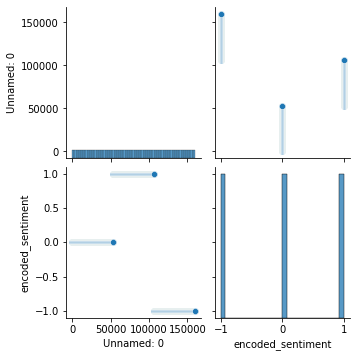

In [4]:
sns.pairplot(df)#,hue='encoded_sentiment')

In [5]:
df['encoded_sentiment'].unique()  # sentiment options

array([ 0,  1, -1])

In [6]:
# check the number of positive vs. negative tagged sentences

positives = df['encoded_sentiment'][df.encoded_sentiment == 1]
neutrals = df['encoded_sentiment'][df.encoded_sentiment == 0]
negatives = df['encoded_sentiment'][df.encoded_sentiment == -1]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of neltral tagged sentences is: {}'.format(len(neutrals)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))


number of positve tagged sentences is:  53283
number of neltral tagged sentences is: 53283
number of negative tagged sentences is: 53283


In [7]:
# definir features & target

X = df.tweet_text
y = pd.get_dummies(df.encoded_sentiment) # Convert categorical variable into dummy/indicator variables.

# Checkout 'y'
print(y.shape)
y.head(3)

(159849, 3)


,-1,0,1
0,0,1,0
1,0,1,0
2,0,1,0


In [8]:
# hold out method - Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
X_train

18107     ['agenda', 'bolsonaro', 'é', 'interrompida', '...
95512                                      ['tô', 'zuando']
62702                                     ['sabe', 'amiga']
140525    ['mais', 'dia', 'acordando', 'não', 'sentando'...
97650                                    ['tirem', 'tédio']
                                ...                        
119879    ['simmm', 'injusto', 'meiqi', 'fãs', 'gastaram...
103694    ['manda', 'conto', 'fábio', 'estamos', 'espera...
131932    ['elô', 'disse', 'feia', 'poxa', 'elô', 'ainda...
146867                       ['queria', 'ter', 'amorzinho']
121958                         ['kkkkkkkkkk', 'é', 'serio']
Name: tweet_text, Length: 127879, dtype: object

In [10]:
y_train.shape

(127879, 3)

## Tokenizer

In [11]:
# Let's tokenize the vocabulary 

tk = Tokenizer() 
tk.fit_on_texts(X_train)  # Fitting each text in text X_train to a sequence of integers.
vocab_size = len(tk.word_index)
vocab_size # number of != words / input_dim - padding 

77423

In [12]:
X_train_token = tk.texts_to_sequences(X_train)  # Transforming each text in X_train to a sequence of integers.
X_test_token = tk.texts_to_sequences(X_test)  # Transforming each text in X_test to a sequence of integers.

# Pad your inputs

X_train_pad = pad_sequences(X_train_token, dtype ='float32', padding = 'post', maxlen=50) # Pads sequences to the same length.

X_test_pad = pad_sequences(X_test_token, dtype ='float32', padding = 'post', maxlen=50) # Pads sequences to the same length.


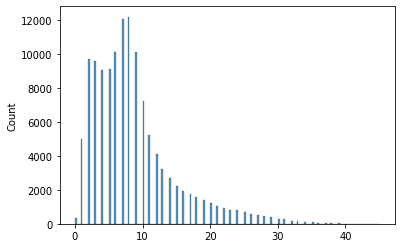

In [13]:
import seaborn as sns
sns.histplot([len(x) for x in X_train_token]);

In [14]:
y.head(3) # target

,-1,0,1
0,0,1,0
1,0,1,0
2,0,1,0


In [15]:
# len(X_train_pad)
X_train_pad.shape, vocab_size

((127879, 50), 77423)

In [16]:
len(y_test)

31970

## Embedding

In [17]:
# Let's build the Neural network now
# Size of your embedding space = size to represent each word

embedding_size = 30

# 1. ARCHITECTURE
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size+1, # vocab_size +1 for the 0 padding
                           input_length = X_train_pad.shape[1], # Max_sentence_length (optional, for model summary)
                           output_dim = 30,
                           mask_zero=True, # Included masking layer :)
                        ))

model.add(layers.LSTM(50))
model.add(layers.Dense(25, activation="relu"))
model.add(layers.Dense(9, activation="relu"))
model.add(layers.Dense(3, activation="softmax"))
model.summary()

2022-03-18 21:59:37.167616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 30)            2322720   
                                                                 
 lstm (LSTM)                 (None, 50)                16200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 9)                 234       
                                                                 
 dense_2 (Dense)             (None, 3)                 30        
                                                                 
Total params: 2,340,459
Trainable params: 2,340,459
Non-trainable params: 0
_________________________________________________________________


In [18]:
y.shape

(159849, 3)

In [19]:
y_test.shape

(31970, 3)

In [20]:
y_train.shape

(127879, 3)

In [21]:
# number of params
print(f'Expected number of parameters : {(vocab_size+1) * embedding_size}')


Expected number of parameters : 2322720


## Compiling

In [22]:
%%time
# 2. COMPILATION  
adam_opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Classification with more classes
model.compile(loss='categorical_crossentropy', 
              optimizer=adam_opt,
              metrics=['accuracy'])
# 3. FIT
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train_pad, y_train,
          batch_size=13, # Too small --> no generalization. Too large --> compute slowly
          epochs=50,
          validation_split=0.2,
          callbacks=[es],
          verbose=1,
          shuffle=True)


Epoch 1/50
7870/7870 [==============================] - 153s 19ms/step - loss: 0.7219 - accuracy: 0.6372 - val_loss: 0.6202 - val_accuracy: 0.6677
Epoch 2/50
7870/7870 [==============================] - 152s 19ms/step - loss: 0.5661 - accuracy: 0.7061 - val_loss: 0.5458 - val_accuracy: 0.7530
Epoch 3/50
7870/7870 [==============================] - 155s 20ms/step - loss: 0.4627 - accuracy: 0.8069 - val_loss: 0.4644 - val_accuracy: 0.8121
Epoch 4/50
7870/7870 [==============================] - 156s 20ms/step - loss: 0.3597 - accuracy: 0.8555 - val_loss: 0.4118 - val_accuracy: 0.8261
Epoch 5/50
7870/7870 [==============================] - 150s 19ms/step - loss: 0.3070 - accuracy: 0.8776 - val_loss: 0.4219 - val_accuracy: 0.8260
Epoch 6/50
7870/7870 [==============================] - 150s 19ms/step - loss: 0.2721 - accuracy: 0.8936 - val_loss: 0.4245 - val_accuracy: 0.8293
Epoch 7/50
7870/7870 [==============================] - 156s 20ms/step - loss: 0.2449 - accuracy: 0.9037 - val_loss: 0

In [23]:
# Testing model

loss, accuracy = model.evaluate(X_test_pad, y_test)
 
print('test loss', loss)
print('test accuracy', accuracy)

1000/1000 [==============================] - 4s 4ms/step - loss: 0.4213 - accuracy: 0.8228
test loss 0.4213147759437561
test accuracy 0.8228338956832886


In [24]:
# # Let's build the Neural network now
# # Size of your embedding space = size to represent each word

# embedding_size = 60

# # 1. ARCHITECTURE
# model = Sequential()
# model.add(layers.Embedding(input_dim = vocab_size+1, # vocab_size +1 for the 0 padding
#                            input_length = X_train_pad.shape[1], # Max_sentence_length (optional, for model summary)
#                            output_dim = 60,
#                            mask_zero=True, # Included masking layer :)
#                         ))

# model.add(layers.LSTM(50))
# model.add(layers.Dense(25, activation="relu"))
# model.add(layers.Dense(9, activation="relu"))
# model.add(layers.Dense(3, activation="softmax"))
# model.summary()

In [25]:
# %%time
# # 2. COMPILATION
# adam_opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# # Classification with more classes
# model.compile(loss='categorical_crossentropy', 
#               optimizer=adam_opt,
#               metrics=['accuracy'])
# # 3. FIT
# es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# model.fit(X_train_pad, y_train,
#           batch_size=64, # Too small --> no generalization. Too large --> compute slowly
#           epochs=100,
#           validation_split=0.2,
#           callbacks=[es],
#           verbose=1,
#           shuffle=True)
          

In [26]:
# rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-8, decay=0.0)

In [27]:
# # 1. ARCHITECTURE
# model = models.Sequential()
# model.add(layers.Dense(50, activation='relu', input_dim=77424)) # eq. input_shape=(77423 + padding)
# model.add(layers.Dense(25, activation='relu'))
# model.add(layers.Dense(25, activation='relu'))
# model.add(layers.Dense(4, activation='softmax')) # What is this model doing? 

In [28]:
# # 2. COMPILATION
# from tensorflow.keras import optimizers
# adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# # Classification with more classes
# model.compile(loss='categorical_crossentropy', 
#               optimizer=adam_opt,
#               metrics=['accuracy'])


In [29]:
# # 3. FIT

# from tensorflow.keras import callbacks

# es = callbacks.EarlyStopping(patience=12, restore_best_weights=True)

# model.fit(X, y,
#           batch_size=32, # Too small --> no generalization. Too large --> compute slowly
#           epochs=100,
#           validation_split=0.3,
#           callbacks=[es],
#           verbose=1)
          

In [30]:
# La razón detrás de esta proporción proviene del tamaño de todo mi conjunto de datos.
# El conjunto de datos tiene más de 1,5 millones de entradas. En este caso, 
# solo el 1% de todos los datos me da más de 15.000 entradas. Esto es más que suficiente 
# para evaluar el modelo y refinar los parámetros.

In [31]:
# dividir los datos en solo un conjunto de entrenamiento y prueba, y ejecutar una validación cruzada k-fold en el 
# conjunto de entrenamiento, para que pueda tener una evaluación imparcial de un modelo. Pero teniendo en cuenta el 
# tamaño de los datos, he decidido usar el conjunto de entrenamiento solo para entrenar un modelo y 
# evaluar en el conjunto de desarrollo, de modo que pueda probar rápidamente diferentes algoritmos y 
# ejecutar este proceso de forma iterativa.

In [32]:
# # RandomForestClassifier
# from sklearn.ensemble import RandomForestClassifier
# model2 = RandomForestClassifier()
# kfold = KFold(n_splits=3, random_state=42, shuffle=True) 
# scores = cross_val_score(model2, X_train, y_train, cv=kfold, scoring='roc_auc')
# scores_mean_rf = scores.mean()
# print("Mean AUC Score - Random Forest: ", scores_mean_rf)

# # Entrenamos el modelo
# model2.fit(X_train, y_train)

# # Comprobamos las metricas tras el entrenamiento
# print("Train Accuracy: {:.3f}".format(model2.score(X_train, y_train)))